In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, f1_score, precision_score, recall_score, mean_squared_error
from sklearn.preprocessing import LabelBinarizer

from source import read_preprocessed_data
from transform import load_process_and_store_spreadsheets
from pipelines import benchmark_pipelines, build_classifier_pipelines, build_regression_pipelines, pipeline_Richard, pipeline_Julian

RANDOM_STATE = 1234

In [3]:
allele_columns = ["T0: Allele \nFraction", "T1: Allele Fraction"]
load_process_and_store_spreadsheets(allele_columns=allele_columns, transformation=lambda x, y: y*x/(x+y))

X_train, y_train = read_preprocessed_data("output/train.tsv")
X_test, y_test = read_preprocessed_data("output/test.tsv")

## Classification

In [4]:
y_train_resp = y_train["response_grouped"] == 'non responder (sd+pd)'
y_test_resp = y_test["response_grouped"] == 'non responder (sd+pd)'

In [5]:
ps_class = build_classifier_pipelines()

In [6]:
b = benchmark_pipelines(
    ps_class, X_train, y_train_resp, X_test, y_test_resp, metric=f1_score,
)
b

,Richard_test,Julian_test,Freeman_test,Lev_test
DecisionTreeClassifier,0.766667,0.765957,0.766667,0.651163
RandomForestClassifier,0.838710,0.695652,0.758621,0.651163
GradientBoostingClassifier,0.830769,0.865672,0.861538,0.830769
KNeighborsClassifier,0.730769,0.680851,0.813559,0.571429
LogisticRegression,0.842105,0.000000,0.842105,0.000000
SVC,0.865672,0.865672,0.865672,0.865672
DummyClassifier,0.865672,0.865672,0.865672,0.865672


In [7]:
print(b.mean(axis=0))
print('--'*10)
print(b.mean(axis=1))

Richard_test    0.820052
Julian_test     0.677068
Freeman_test    0.824833
Lev_test        0.633695
dtype: float64
--------------------
DecisionTreeClassifier        0.737613
RandomForestClassifier        0.736036
GradientBoostingClassifier    0.847187
KNeighborsClassifier          0.699152
LogisticRegression            0.421053
SVC                           0.865672
DummyClassifier               0.865672
dtype: float64


In [8]:
p_win = ps_class['DecisionTreeClassifier']['Julian']

Confusion matrix, without normalization
[[ 9  0]
 [11 18]]


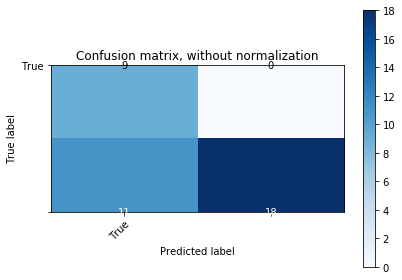

In [9]:
from views import plot_confusion_matrix
plot_confusion_matrix(y_test_resp, p_win.predict(X_test), classes=y_test_resp.unique())

In [10]:
recall = benchmark_pipelines(
    ps_class, X_train, y_train_resp, X_test, y_test_resp, metric=recall_score,
)
recall

,Richard_test,Julian_test,Freeman_test,Lev_test
DecisionTreeClassifier,0.793103,0.620690,0.793103,0.482759
RandomForestClassifier,0.896552,0.551724,0.758621,0.482759
GradientBoostingClassifier,0.931034,1.000000,0.965517,0.931034
KNeighborsClassifier,0.655172,0.551724,0.827586,0.413793
LogisticRegression,0.827586,0.000000,0.827586,0.000000
SVC,1.000000,1.000000,1.000000,1.000000
DummyClassifier,1.000000,1.000000,1.000000,1.000000


Confusion matrix, without normalization
[[ 9  0]
 [29  0]]


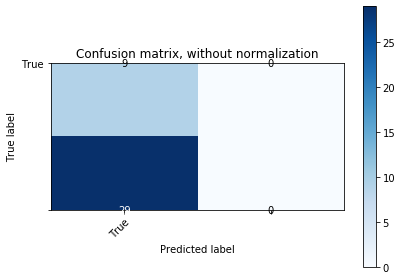

In [11]:
from views import plot_confusion_matrix
plot_confusion_matrix(y_test_resp, ps_class['LogisticRegression']['Lev'].predict(X_test), classes=y_test_resp.unique())

## Dimensional representation

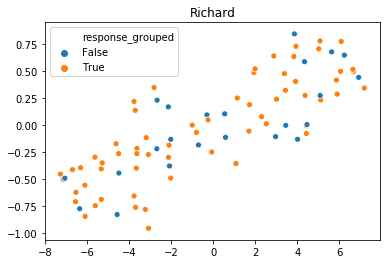

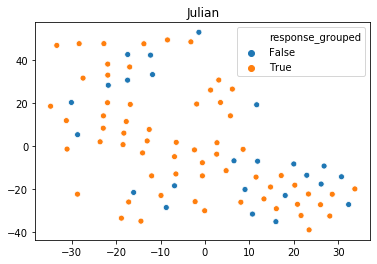

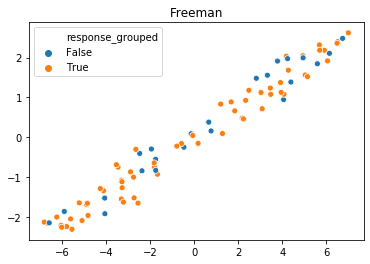

In [12]:
from views import view_pipelines

view_pipelines(ps_class['LogisticRegression'], X_train, y_train_resp, random_state=RANDOM_STATE)

## Regression

In [13]:
y_train_os = y_train['OS_days']
y_test_os = y_test['OS_days']
y_train_pfs = y_train['PFS_days']
y_test_pfs = y_test['PFS_days']

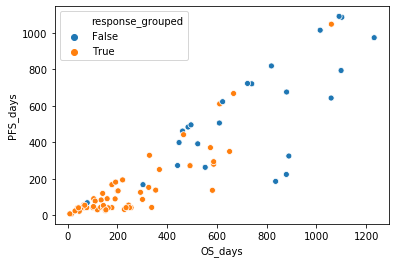

In [14]:
sns.scatterplot(x=y_train_os, y=y_train_pfs, hue=y_train_resp)

### Overall survival (OS)

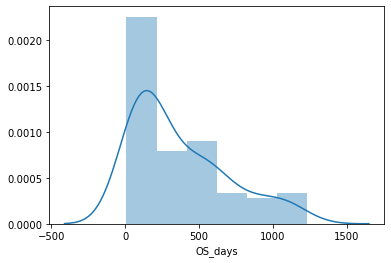

In [15]:
sns.distplot(y_train_os)

In [16]:
ps = build_regression_pipelines()
b = benchmark_pipelines(ps, X_train, y_train_os, X_test, y_test_os, metric=mean_squared_error)
# Root mean squared error.
b = b**0.5

In [17]:
print(b.mean(axis=0))
print('--'*10)
print(b.mean(axis=1))

Richard_test    316.799757
Julian_test     273.258122
Freeman_test    638.191486
Lev_test        285.578584
dtype: float64
--------------------
DecisionTreeRegressor        314.279185
RandomForestRegressor        305.809359
GradientBoostingRegressor    293.900891
KNeighborsRegressor          332.909133
ElasticNet                   270.817548
LinearRegression             956.175452
SVR                          276.691522
DummyRegressor               277.072810
dtype: float64


In [18]:
b

,Richard_test,Julian_test,Freeman_test,Lev_test
DecisionTreeRegressor,376.021202,255.227153,325.070220,300.798164
RandomForestRegressor,343.277793,289.205408,285.673707,305.080527
GradientBoostingRegressor,316.987848,266.030076,306.855242,285.730396
KNeighborsRegressor,369.776634,289.899266,361.913946,310.046687
ElasticNet,271.507413,271.744500,271.537322,268.480957
LinearRegression,302.710133,260.780187,3000.364169,260.847317
SVR,277.044226,276.105578,277.044472,276.571812
DummyRegressor,277.072810,277.072810,277.072810,277.072810


## Progression Free Survival (PFS)

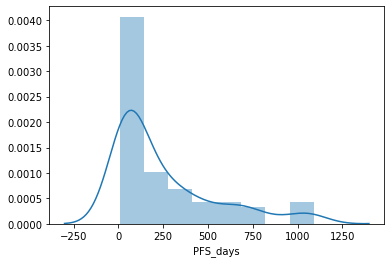

In [19]:
y_train_pfs = y_train['PFS_days']
y_test_pfs = y_test['PFS_days']
sns.distplot(y_train_pfs)

In [20]:
ps = build_regression_pipelines()
b = benchmark_pipelines(ps, X_train, y_train_pfs, X_test, y_test_pfs, metric=mean_squared_error)
# Root mean squared error.
b = b**0.5

In [21]:
print(b.mean(axis=0))
print('--'*10)
print(b.mean(axis=1))

Richard_test    311.473587
Julian_test     293.137569
Freeman_test    384.899778
Lev_test        293.423473
dtype: float64
--------------------
DecisionTreeRegressor        322.459104
RandomForestRegressor        290.494692
GradientBoostingRegressor    292.074357
KNeighborsRegressor          331.990772
ElasticNet                   278.750185
LinearRegression             452.765383
SVR                          298.611781
DummyRegressor               298.722543
dtype: float64


In [22]:
b

,Richard_test,Julian_test,Freeman_test,Lev_test
DecisionTreeRegressor,361.213276,272.840127,350.335608,305.447406
RandomForestRegressor,291.047843,293.009093,296.130773,281.791057
GradientBoostingRegressor,307.619806,283.096726,285.597283,291.983611
KNeighborsRegressor,353.867007,320.053519,336.586037,317.456525
ElasticNet,273.793199,288.689546,273.805864,278.712128
LinearRegression,306.814569,290.240609,939.309743,274.696610
SVR,298.710452,298.448391,298.710375,298.577905
DummyRegressor,298.722543,298.722543,298.722543,298.722543


## Multitask model


In [23]:
from sklearn.linear_model import MultiTaskElasticNet
from pipelines import pipelines
ps = pipelines(MultiTaskElasticNet, VotingEstimator=None)

In [24]:
Y_train = y_train[['OS_days', 'PFS_days']]
Y_test = y_test[['OS_days', 'PFS_days']]
rmse = lambda a, b: mean_squared_error(a, b, multioutput='raw_values')**0.5
benchmark_pipelines({'bla': ps}, X_train, Y_train, X_test, Y_test, metric=rmse)
# p = ps['Richard']
# p.fit(X_train, Y_train)

,Freeman_test,Julian_test,Richard_test
bla,"[268.42224374066984, 273.7039715426234]","[271.7399772705852, 288.69028307704565]","[268.40506641346275, 273.6944998454938]"
